# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Признаки**: пол, возраст и зарплата застрахованного, количество членов его семьи.<br>
**Целевой признак**: количество страховых выплат клиенту за последние 5 лет.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from numpy.random import RandomState
from pylab import rcParams
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize


In [2]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 12345

<Figure size 864x576 with 0 Axes>

In [3]:
# сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()
    if show_corr_null_plots:
        # готовим матрицу корреляций нулей
        t = df.isna().sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NULL in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NULL values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    if show_scatter_matrix:
        pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);


In [138]:
try:
    df = pd.read_csv('/datasets/insurance.csv', sep=',')
except:
    df = pd.read_csv('datasets\yandex_10_insurance.csv', sep=',')



------SAMPLE--------


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
3598,1,29.000,"23,400.000",3,0
2555,1,21.000,"42,200.000",0,0
4709,0,24.000,"34,700.000",0,0
4942,0,31.000,"47,300.000",1,0
608,0,25.000,"47,700.000",3,0



------DTYPES--------
Пол                    int64
Возраст              float64
Зарплата             float64
Члены семьи            int64
Страховые выплаты      int64
dtype: object


------NaN & zero--------
                  NA  filled  zero %na
Пол                -    5000  2505   -
Возраст            -    5000     -   -
Зарплата           -    5000     -   -
Члены семьи        -    5000  1513   -
Страховые выплаты  -    5000  4436   -



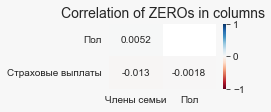

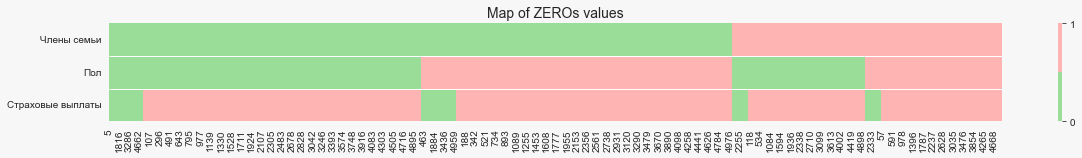

,count,mean,std,min,25%,50%,75%,max
Пол,"5,000.000",0.499,0.500,0.000,0.000,0.000,1.000,1.000
Возраст,"5,000.000",30.953,8.441,18.000,24.000,30.000,37.000,65.000
Зарплата,"5,000.000","39,916.360","9,900.084","5,300.000","33,300.000","40,200.000","46,600.000","79,000.000"
Члены семьи,"5,000.000",1.194,1.091,0.000,0.000,1.000,2.000,6.000
Страховые выплаты,"5,000.000",0.148,0.463,0.000,0.000,0.000,0.000,5.000


In [5]:
evaluate_df(df, True, True)

**Вывод**

- Данные не имеют пропусков, нет аномалий, выбросов. Данные качественные и чистые
- Названия столбцов в кириллице, но т.к. мы будем работать с матрицами, то названия нам не понадобятся


## Умножение матриц

Обозначения

- m наблюдений

- n-1 признаков и 1 единичный столбец

- $F$ - матрица признаков m * n-1

- $X$ — расширенная матрица признаков m * n. Связана с матрицей $F$ добавлением единичного столбца 
$
X = \begin{vmatrix}
1 & F
\end{vmatrix}
$

- $y$ — вектор целевого признака m * 1

- $R$ — матрица, на которую умножаются признаки n * n

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу) n * 1


Предсказания:

$$
\hat{y} = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Тогда предсказания
$$\hat{y}=X\left({X}^TX\right)^{-1}{X}^T{y}$$

**Ответ:** При умножении матрицы признаков $X$ на любую обратимую матрицу $R$ качество линейной регрессии не изменится.

Параметры линейной регрессии в исходной задаче $w$ и в преобразованной задаче $w'$ связаны соотношением

$$R^{-1}w = w'$$

**Обоснование:** 

Формируем новую матрицу признаков Z (m * n)
$$Z=XR$$

Посчитаем предсказания для новой матрицы признаков Z
$$\hat{y'}=Z\left({Z}^TZ\right)^{-1}{Z}^T{y}$$
$$\hat{y'}=(XR)\left({\left(XR\right)}^T(XR)\right)^{-1}{\left(XR\right)}^T{y}$$


Учитывая свойства транспонирования произведения матриц и обратной матрицы к произведению матриц:

$$(AB)^T=B^TA^T$$

$$(AB)^{-1}=B^{-1}A^{-1}$$

$$\hat{y'}=XR{\left(R^TX^TXR\right)}^{-1}R^TX^T{y}$$

$$\hat{y'}=XRR^{-1}\left({X}^TX\right)^{-1}{\left(R^T\right)}^{-1}R^TX^T{y}$$

Учтем, что $E = RR^{-1}$  и $E = {\left(R^T\right)}^{-1}R^T$, тогда

$$\hat{y'}=XE\left({X}^TX\right)^{-1}EX^T{y}$$

$$\hat{y'}=X\left({X}^TX\right)^{-1}X^T{y}$$
$$\hat{y'}=\hat{y}$$

Таким образом, прогноз (predict) не изменился вовсе после умножения матрицы признаков $X$ на произвольную обратимую матрицу $R$. Соответственно и качество регрессии R2 не изменится, т.е. ни вектор целевого признака ни вектор прогнозов не изменится

Тогда т.к. $\hat{y} = Xw$ и $\hat{y'} = XRw'$ и $\hat{y'}=\hat{y}$, то

$$Xw= XRw'$$

$$X^{-1}Xw= X^{-1}XRw'$$

$$Ew= ERw'$$

$$R^{-1}w= R^{-1}Rw'$$

$$R^{-1}w = Ew'$$

$$R^{-1}w = w'$$
$$w = Rw'$$

таким образом, зная коэффициенты новой модели, можно получить коэффициенты старой модели

## Алгоритм преобразования

**Алгоритм**

1. сгенерировать произвольную матрицу $P$ размером n-1 * n-1. Матрица $P$ создает линейную комбинацию столбцов матрицы $F$, перемешивает их как бы.
2. Проверить что она обратима. Иначе вернуться к пункту 1
3. Нормировать столбцы матрицы $F_n=F N$ так, чтобы не было признаков с явно большими или низкими значениями. Нормирование производит диагональная матрица у которой на главной диагонали стоят значения, обратные максимальным в столбцах матрицы $F$
4. Вычислить итоговую матрицу признаков с учетом нормирования и случайного линейного преобразования $F_2 = F N P$
5. Повторно нормировать столбцы матрицы $F_{n2}=F_2 N_2$ так, чтобы после линейного преобразования не было признаков с явно большими или низкими значениями
5. Вычислить матрицу преобразования $P\_ = N P N_2$
6. Новую матрицу $F_{n2}$ считать новой матрицей признаков, для расширенной матрицы признаков добавить столбец 1
7. Матрицу $P\_$ считать матрицей преобразования признаков


**Обоснование**

Используем, что матрица R **произвольная** невырожденная

Пусть тогда левый верхний элемент 1, а все остальные элементы верхней строки и левого столбца нули. Остальные элементы матрицы образуют подматрицу размера n-1 * n-1. Обозначим эту подматрицу P.

Матрицы P и R связаны:
$$
R = \begin{vmatrix}
1 & 0\\
0 & P
\end{vmatrix}
$$

Если $P$ будет невырожденной, то и $R$ будет невырожденной, т.к. $det(R) = 1 * det(P)$

Преобразование сконструировано так, чтобы матрица модификации $P$ меняла только матрицу признаков $F$, но не столбец единиц. Это  сделано для того, чтобы мы могли преобразовать и передать защищенные данные с тем же числом признаков, что и исходные данные. При этом не передавая модифицированный столбец единиц (что было бы глупо)

Нормирование матрицы позволит скрыть масштаб признаков, чтолы по масштабу нелья было примерно догадаться об истинных значениях признаков

При таком преобразовании наилучшая модель линейной регрессии будет иметь то же качество модели и будет выдавать те же самые предсказания, при этом, признаки (новой матрицы) будут являться линейными комбинациями  из старой матрицы признаков со случайными коэффициентами (умножение на матрицу P), что позволит скрыть истинные данные, но не помешает строить линейные модели той же эффективности как и на исхоных данный и получать те же прогнозы.





## Проверка алгоритма

Создадим две функции. Одну для подсчета функции потерь R2, вторую для генерации случайной матрицы n-1*n-1

In [260]:
def check_quality_linreg(X, y):
    # используем multi_dot чтобы максимально эффективно перемножить несколько матриц
    w = np.linalg.multi_dot([np.linalg.inv(X.T @ X), X.T, y])
    y_ = X @ w
    r2 = r2_score(y,y_)
    return r2, w

def generate_P(F,n):
    ans = False
    for i in range(100):
        # Делаем случайную квадратную матрицу, чтобы не было сильно мелких значений 
        # и чтобы определитель матрицы не был сильно маленьким (иначе при вычислении 
        # обратных матриц получаются погрешности вычислительные)
        P = np.random.uniform(low=1, high=10, size=(n-1,n-1)) 
        
        if abs(np.linalg.det(P)) > 0.01:
            break;
    if i >= 100:
        print('ERROR. Fail to generate R after', i, 'trials')
        return False
    else:        
        # нормализация линейная!
        # Fn = normalize(F, axis=0, norm='l1')*100 + np.ones((m,n-1))
        Pn = np.diag(1/pd.DataFrame(F).max().values)
        Pn2 = np.diag(1/pd.DataFrame(F@Pn@P).max().values)
        P_ = Pn @ P @ Pn2
        
#         display('FP',pd.DataFrame(F@P).head(10))
#         display('FPn',pd.DataFrame(F@Pn).head(10))
#         display('FP_',pd.DataFrame(F@P_).head(10))
#         display('P',pd.DataFrame(P))
        return P_


Выделяем признаки и целевой признак, считаем функцию потерь

далее модифицируем матрицу признаков и снова считаем функцию потерь

In [251]:
feautures = df.drop(['Страховые выплаты'], axis=1).values
target = df['Страховые выплаты'].values

np.random.seed(1245)

m = feautures.shape[0]
n = feautures.shape[1]+1
X0 = np.ones((m,1))
X = np.hstack((X0,feautures))
y = target


P = generate_P(feautures, n)
X_new = np.hstack((X0,feautures @ P))

# считаем коэффициент r2 и коэффициенты регрессии
r2_orig, w_orig = check_quality_linreg(X, y)
r2_new, w_new = check_quality_linreg(X_new, y)

print('Исходное качество \t   R2 =', r2_orig)
print('После модификации качество R2 =', r2_new)

print('Разница R2', r2_new - r2_orig)



Исходное качество 	   R2 = 0.42494550286668
После модификации качество R2 = 0.42494550286668
Разница R2 0.0


Посмотрим на преобразованную матрицу. Изучим ее статистики

In [257]:
F_orig = pd.DataFrame(feautures)
F_orig.head(10)

,0,1,2,3
0,1.000,41.000,"49,600.000",1.000
1,0.000,46.000,"38,000.000",1.000
2,0.000,29.000,"21,000.000",0.000
3,0.000,21.000,"41,700.000",2.000
4,1.000,28.000,"26,100.000",0.000
5,1.000,43.000,"41,000.000",2.000
6,1.000,39.000,"39,700.000",2.000
7,1.000,25.000,"38,600.000",4.000
8,1.000,36.000,"49,700.000",1.000
9,1.000,32.000,"51,700.000",1.000


In [258]:
F_transformed = pd.DataFrame(feautures @ P)
display(F_transformed.head(10))
F_transformed.describe()

,0,1,2,3
0,0.815,0.779,0.763,0.789
1,0.565,0.259,0.576,0.639
2,0.334,0.122,0.324,0.366
3,0.376,0.287,0.424,0.465
4,0.595,0.622,0.520,0.521
5,0.819,0.795,0.791,0.802
6,0.779,0.784,0.752,0.760
7,0.687,0.856,0.718,0.699
8,0.771,0.773,0.722,0.744
9,0.743,0.775,0.696,0.717


,0,1,2,3
count,"5,000.000","5,000.000","5,000.000","5,000.000"
mean,0.568,0.496,0.558,0.588
std,0.152,0.249,0.131,0.120
min,0.200,0.068,0.193,0.217
25%,0.434,0.251,0.459,0.502
50%,0.578,0.460,0.559,0.584
75%,0.688,0.732,0.651,0.671
max,1.000,1.000,1.000,1.000


Как видим, имеющиеся данные в матрице модифицированых признаков практически не позволяют догадаться об изначальных значениях исходных признаков.

Посмотрим на корреляции исходных признаков и после трансформации

In [259]:
pd.concat([F_orig,F_transformed], axis=1).corr()

,0,1,2,3,0,1,2,3
0,1.000,0.002,0.015,-0.009,0.831,0.966,0.708,0.588
1,0.002,1.000,-0.019,-0.007,0.488,0.043,0.536,0.632
2,0.015,-0.019,1.000,-0.030,0.240,0.164,0.280,0.382
3,-0.009,-0.007,-0.030,1.000,0.112,0.193,0.348,0.307
0,0.831,0.488,0.240,0.112,1.000,0.885,0.962,0.929
1,0.966,0.043,0.164,0.193,0.885,1.000,0.824,0.719
2,0.708,0.536,0.280,0.348,0.962,0.824,1.000,0.982
3,0.588,0.632,0.382,0.307,0.929,0.719,0.982,1.000


Посмотрим на матрицы рассеяния до и после преобразования

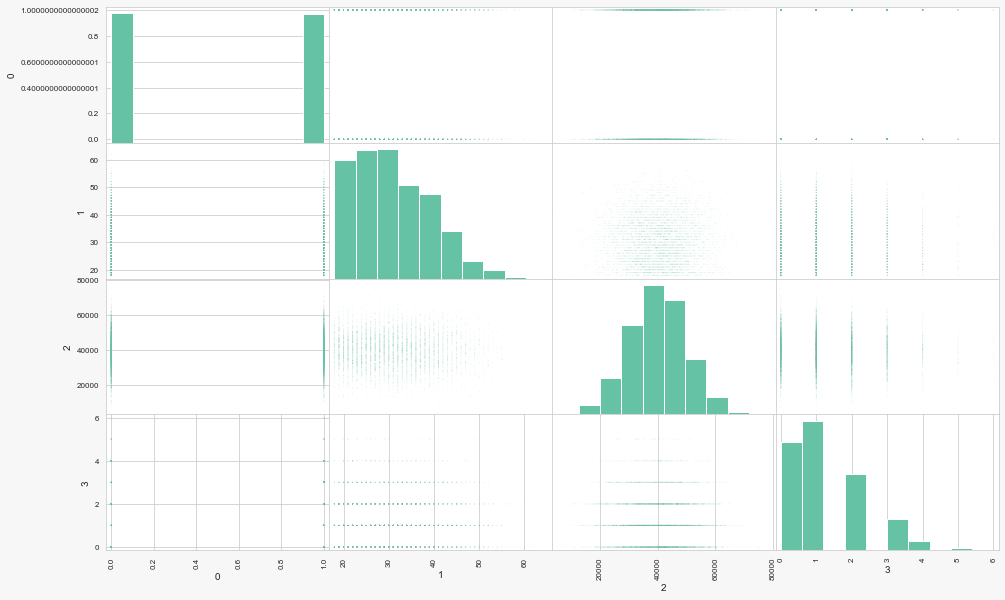

In [256]:
pd.plotting.scatter_matrix(q, figsize=(16,10), alpha=0.1, s=5);

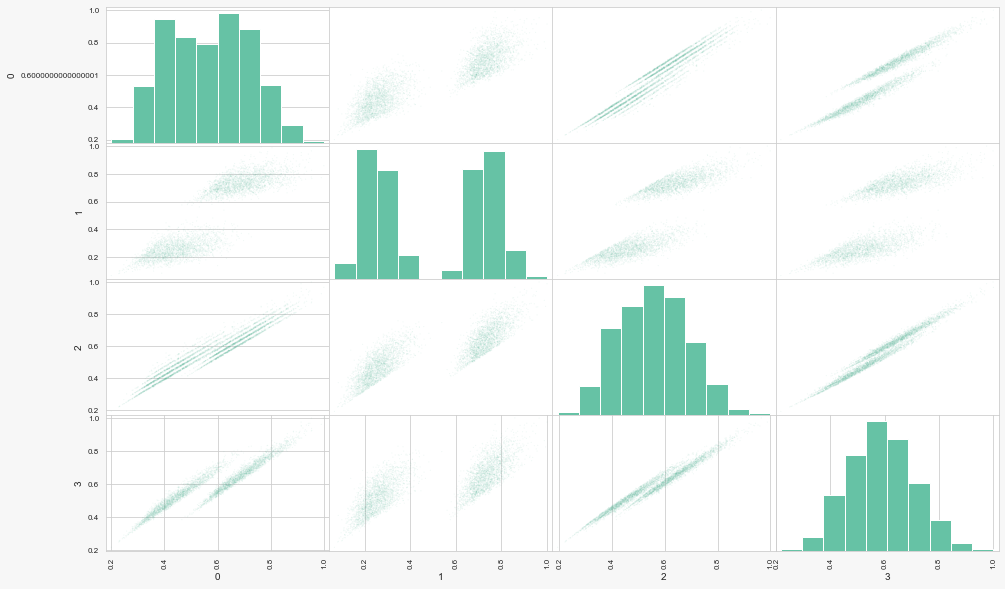

In [255]:
pd.plotting.scatter_matrix(t, figsize=(16,10), alpha=0.1, s=5);

Линейное преобразование на первый взгляд делает хорошую маскировку исходных данных. Но для дискретных значений (пол/число детей) эту дискретность сложно скрыть и даже после преобразования на матрие рассеяния видны следы от этой дискретности отдельных признаков.

In [220]:
# считаем коэффициенты регрессии с обратным преобразованием
w_new_rev = np.concatenate([w_new[:1], P @ w_new[1:]])

In [221]:
print('Исходные коэффициенты w =\n',list(w_orig))
print('Новые коэффициенты    w =\n',list(w_new))
print('Новые с обратным преобразованием коэффициенты w =\n',list(w_new_rev))

print('\nРазница исходных и новых с обратным преобразованием delta =\n',list(w_orig - w_new_rev))


Исходные коэффициенты w =
 [-0.9382355041524781, 0.007925805428953658, 0.03570830502107245, -1.7008049156483622e-07, -0.013567662269755157]
Новые коэффициенты    w =
 [-0.9382355041525532, 0.6382315033033237, 0.09320315193855322, 1.9551454778277417, -0.24033130001689607]
Новые с обратным преобразованием коэффициенты w =
 [-0.9382355041525532, 0.007925805428964594, 0.03570830502107221, -1.7008049156314216e-07, -0.01356766226976075]

Разница исходных и новых с обратным преобразованием delta =
 [7.505107646466058e-14, -1.0935696792557792e-14, 2.42861286636753e-16, -1.6940658945086007e-18, 5.592748486549226e-15]


**Вывод**

* Видим, что после модификации качество модели осталось прежним (с точностью до машинной погрешности при вычислениях)

* Преобразование было сделано так, чтобы матрица модификации P меняла только матрицу признаков, но не столбец единиц. Это было сделано для того, чтобы мы могли преобразовать (защитить) и передать защищенные данные с тем же числом признаков, что и исходные данные.
* Линейное нормирование матрицы позволило скрыть масштаб признаков, чтолы по масштабу нелья было примерно догадаться об истинных значениях признаков

* Коэффициенты новой модели отличаются, но обратимы с помощью линейного обратного преобразования
